In [27]:
from utils.functions import *
from utils.display import *
from datasets import Dataset
from sklearn.covariance import MinCovDet, LedoitWolf, OAS
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

import plotly.express as px
import utils.constant as c
import seaborn as sns

sns.set_style("white")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
dataset = "bae"

data = pd.read_csv(rf"data DO NOT USE/attacks/{dataset}.csv")

mask_success = data["result_type"] == "Successful"
data = data.loc[mask_success]

data_attack = data[["perturbed_text"]]
data_attack.columns = ["text"]
data_original = data[["original_text"]]
data_original.columns = ["text"]

In [116]:
dataset_attack = Dataset.from_pandas(data_attack)
dataset_original = Dataset.from_pandas(data_original)

data_loader_attack = torch.utils.data.DataLoader(
    dataset_attack, batch_size=16, shuffle=False
)
data_loader_original = torch.utils.data.DataLoader(
    dataset_original, batch_size=16, shuffle=False
)

In [117]:
# We run Bert over all the test and train dataset and get the last hidden state before applying softmax (dim=768)

attack_embedding, attack_softmax = run_model(data_loader_attack, output_hs=True)
torch.save(attack_embedding, f"eric//attack_embedding")
torch.save(attack_softmax, f"eric//attack_softmax")
# attack_embedding = torch.load(r"eric/attack_embedding")
# attack_softmax = torch.load(r"eric/attack_softmax")

original_embedding, original_softmax = run_model(data_loader_original, output_hs=True)
torch.save(original_embedding, f"eric//original_embedding")
torch.save(original_softmax, f"eric//original_softmax")
# original_embedding = torch.load(r"eric/original_embedding")
# original_softmax = torch.load(r"eric/original_softmax")

100%|██████████| 65/65 [02:07<00:00,  1.97s/it]


In [119]:
# scaling the data

scaler = StandardScaler()

original_embedding = scaler.fit_transform(original_embedding)
attack_embedding = scaler.transform(attack_embedding)

In [121]:
# We fit the PCA with respect to the test_embedding

linear_pca = KernelPCA(n_components=2, kernel="linear", random_state=c.rd_state)

PCA_original_embedding = linear_pca.fit_transform(original_embedding)
PCA_attack_embedding = linear_pca.transform(attack_embedding)

In [122]:
df_embedding = pd.DataFrame(
    [*PCA_original_embedding, *PCA_attack_embedding], columns=["x", "y"]
)

labels = ["original" for _ in range(len(PCA_original_embedding))] + [
    "attack" for _ in range(len(PCA_attack_embedding))
]
df_embedding["labels"] = labels
df_embedding["labels"] = df_embedding["labels"].astype(str)

# Scatter plot of embedded points

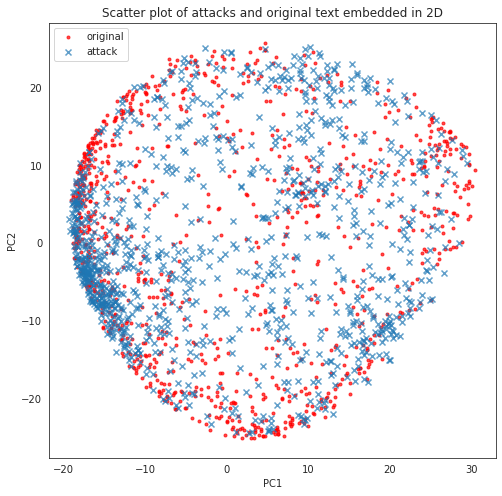

In [184]:
plt.figure(figsize=(8, 8))
plt.scatter(
    PCA_original_embedding[:, 0],
    PCA_original_embedding[:, 1],
    color="red",
    label="original",
    marker=".",
    alpha=0.7,
)
plt.scatter(
    PCA_attack_embedding[:, 0],
    PCA_attack_embedding[:, 1],
    label="attack",
    marker="x",
    alpha=0.7,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="upper left")
plt.title("Scatter plot of attacks and original text embedded in 2D")
plt.show()

## Generating contour plot for Original Text Embedding

In [126]:
fit_mcd_s = MinCovDet(random_state=c.rd_state).fit(PCA_original_embedding)
fit_lw_s = LedoitWolf().fit(PCA_original_embedding)
fit_oas_s = OAS().fit(PCA_original_embedding)

cov_mcd_s = fit_mcd_s.covariance_
mean_mcd_s = fit_mcd_s.location_
cov_lw_s = fit_lw_s.covariance_
mean_lw_s = fit_lw_s.location_
cov_oas_s = fit_oas_s.covariance_
mean_oas_s = fit_oas_s.location_

x1_mcd_s, x2_mcd_s, p_mcd_s = generate_surface(mean_mcd_s, cov_mcd_s, 2)
x1_lw_s, x2_lw_s, p_lw_s = generate_surface(mean_lw_s, cov_lw_s, 2)
x1_oas_s, x2_oas_s, p_oas_s = generate_surface(mean_oas_s, cov_oas_s, 2)

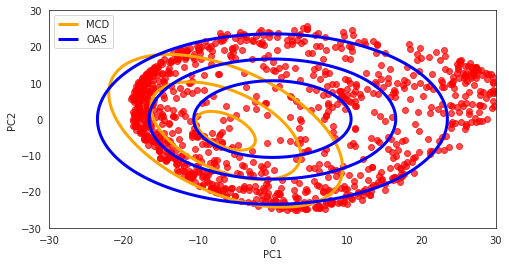

In [156]:
# original
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.scatter(
    x=PCA_original_embedding[:, 0],
    y=PCA_original_embedding[:, 1],
    color="red",
    alpha=0.7,
)
con1 = ax.contour(x1_mcd_s, x2_mcd_s, p_mcd_s, 3, colors="orange", linewidths=3)
con2 = ax.contour(x1_oas_s, x2_oas_s, p_oas_s, 3, colors="blue", linewidths=3)

labels = ["MCD", "OAS", "LW"]
con1.collections[0].set_label(labels[0])
con2.collections[0].set_label(labels[1])
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
ax.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="upper left")
plt.title("Contour plot of the original embedded points")

fig.show()

## Generating contour plot for Attacked Text Embedding

In [128]:
fit_mcd_f = MinCovDet(random_state=c.rd_state).fit(PCA_attack_embedding)
fit_lw_f = LedoitWolf().fit(PCA_attack_embedding)
fit_oas_f = OAS().fit(PCA_attack_embedding)

cov_mcd_f = fit_mcd_f.covariance_
mean_mcd_f = fit_mcd_f.location_
cov_lw_f = fit_lw_f.covariance_
mean_lw_f = fit_lw_f.location_
cov_oas_f = fit_oas_f.covariance_
mean_oas_f = fit_oas_f.location_

x1_mcd_f, x2_mcd_f, p_mcd_f = generate_surface(mean_mcd_f, cov_mcd_f, 2)
x1_lw_f, x2_lw_f, p_lw_f = generate_surface(mean_lw_f, cov_lw_f, 2)
x1_oas_f, x2_oas_f, p_oas_f = generate_surface(mean_oas_f, cov_oas_f, 2)

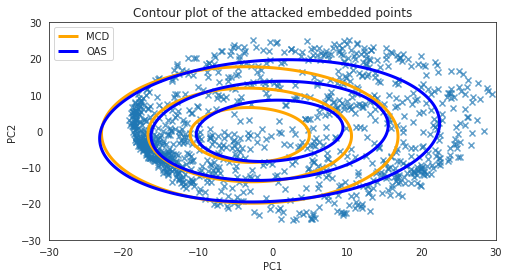

In [183]:
# attack
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
ax.scatter(
    x=PCA_attack_embedding[:, 0], y=PCA_attack_embedding[:, 1], marker="x", alpha=0.7
)
con1 = ax.contour(x1_mcd_f, x2_mcd_f, p_mcd_f, 3, colors="orange", linewidths=3)
con2 = ax.contour(x1_oas_f, x2_oas_f, p_oas_f, 3, colors="blue", linewidths=3)
# con3 = ax.contour(x1_lw_f, x2_lw_f, p_lw_f, 3, colors="blue")

labels = ["MCD", "OAS", "LW"]
con1.collections[0].set_label(labels[0])
con2.collections[0].set_label(labels[1])
con3.collections[0].set_label(labels[2])
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="upper left")
plt.title("Contour plot of the attacked embedded points")

fig.show()